In [1]:
import scipy.io as io
import numpy as np
import pandas as pd
import seaborn as sns
import timeit
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [2]:
def pca_run(X, y, fig = True):
    count = 0
    norm = []
    anom = []
    for i in y:
        if i == 0:
            norm.append(count)
        else:
            anom.append(count)
        count += 1
    
    pca = PCA(n_components=2)
    X_new = pca.fit_transform(X)
    
    if fig:
        plt.plot(X_new[norm, 0], X_new[norm, 1], 'bo', label = 'Normal')
        plt.plot(X_new[anom, 0], X_new[anom, 1], 'r*', label = 'Anomaly')
        plt.legend()
        plt.ylabel('PCA Component 2')
        plt.xlabel('PCA Component 1')
        plt.show()

    #return X_new

In [3]:
def pca_mle(X, y, fig = True):
    count = 0
    norm = []
    anom = []
    for i in y:
        if i == 0:
            norm.append(count)
        else:
            anom.append(count)
        count += 1
    
    pca = PCA(n_components='mle')
    X_new = pca.fit_transform(X)
    
    if fig:
        figg = plt.figure()
        plt.plot(X_new[norm, 0], X_new[norm, 1], 'bo', label = 'Normal')
        plt.plot(X_new[anom, 0], X_new[anom, 1], 'r*', label = 'Anomaly')
        plt.legend()
        plt.ylabel('PCA Component 2')
        plt.xlabel('PCA Component 1')
        plt.show()
        figg.savefig('pca.png', format='png', dpi=1200)

    return X_new, y

In [4]:
def cy(y):
    newy = y.copy()
    newy = newy.astype('int32')
    newy[np.argwhere(y == 1)] = -1
    newy[np.argwhere(y == 0)] = int(1)
    newy = newy.flatten()
    newy = newy.flatten()
    return newy

### Standardized

In [5]:
voldata = pd.read_csv('standard_all.csv')

In [6]:
X = np.concatenate((voldata[voldata.columns[1:18]].values[0:8395],voldata[voldata.columns[1:18]].values[8395:]), axis=0)
y = np.concatenate((voldata[voldata.columns[18]].values[0:8395],voldata[voldata.columns[18]].values[8395:]), axis=0)

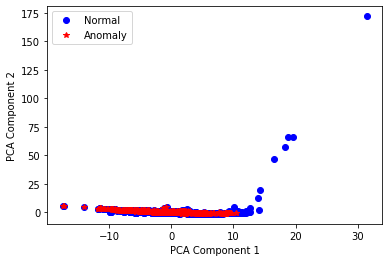

In [7]:
pca_run(X, y)

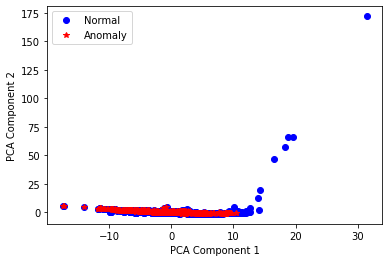

In [8]:
Xvall = pca_mle(X,y)

In [9]:
def limit_y(X, y, per):
    count = 0
    norm = []
    anom = []
    for i in y:
        if i == 0:
            norm.append(count)
        else:
            anom.append(count)
        count += 1
    rp = np.array(np.random.permutation(np.size(anom)))
    anom = np.array(anom)
    norm = np.array(norm)
    num = int((per/(1-per)) * len(norm))
    newy = np.concatenate((y[norm], y[anom[rp[0:num]]]))
    newX = np.concatenate((X[norm, :], X[anom[rp[0:num]], :]))
    return newX, newy

In [10]:
X_, y_ = limit_y(X, y, .10)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state = 3)

In [12]:
def F1Calc(est_y, y):
    out = np.argwhere(y == -1)
    tp = sum(est_y[out] == y[out])
    anom = np.size(out);
    pos = sum((est_y == -1));
    rec = float(tp) / anom;
    try:
        prec = float(tp) / pos;
        F1 = (2 * prec * rec) / (prec + rec);
    except ZeroDivisionError:
        F1 = 0
    return F1


In [13]:
def print_stats(est_y, newy):
    compare = sum(est_y == newy)
    anom = np.argwhere(newy == -1);
    fanom = est_y[anom] == newy[anom];
    found = float(sum(fanom)) / np.size(anom) * 100;

    print('Accuracy:', float(compare) / np.size(newy) * 100)
    print('\nF1 Score:', F1Calc(est_y, newy))
    print('\nPercent Anomalies Found:', found)

In [14]:
newy_test = cy(y_test)
newy = cy(y_)

In [15]:
#outlier detecter
clf = LocalOutlierFactor(n_neighbors = 1)
est_y = clf.fit_predict(X_)
print_stats(est_y, newy)

Accuracy: 75.48788333690757

F1 Score: 0.15707964601769914

Percent Anomalies Found: 22.854077253218886


In [16]:
#novelty detection
nov = LocalOutlierFactor(n_neighbors = 1, novelty = True)
nov.fit(X_train)
est_ytest = nov.predict(X_test)
print_stats(est_ytest, newy_test)

Accuracy: 76.20578778135048

F1 Score: 0.1590909090909091

Percent Anomalies Found: 24.85207100591716


In [17]:
#isolation forest
model = IsolationForest(n_estimators=61, max_samples=10,max_features=1)
model.fit(X_train)
est_ytest2 = model.predict(X_test)
print_stats(est_ytest2, newy_test)

Accuracy: 64.46945337620579

F1 Score: 0.1423027166882277

Percent Anomalies Found: 32.544378698224854


In [18]:
def calc_stats(acc, f1, p_anom, prec, est_y, ytest):
    compare = sum(est_y == ytest)
    anom = np.argwhere(ytest == -1);
    fanom = est_y[anom] == ytest[anom];
    anomm = np.argwhere(est_y == -1)
    found = float(sum(fanom)) / np.size(anom) * 100;
    try:
        precc = float(sum(fanom)) / np.size(anomm) * 100;
    except ZeroDivisionError:
        precc = 0
    

    acc[i] = float(compare) / np.size(ytest) * 100
    f1[i] = F1Calc(est_y, ytest)
    p_anom[i] = found
    prec[i] = precc
    return [acc, f1, p_anom, prec]
    

In [19]:
def plotvar(n_est, acc, p_anom, prec, f1, rtime, method, variable, typ, showtime):
    f = plt.figure()
    name = method + variable + typ + '.png'
    plt.plot(n_est, acc,label = 'Accuracy')
    plt.plot(n_est, p_anom,label = 'Percent Anomalies')
    plt.plot(n_est, prec, label = 'Precision')
    plt.plot(n_est, f1*100, label = 'F1')
    ind = np.argmax(f1)
    plt.plot(n_est[ind],f1[ind]*100, '*', label = 'Highest F1 Score')
    plt.legend()
    plt.title(method)
    plt.xlabel(variable)
    plt.show()
    f.savefig(name, format = 'png', dpi = 1200)
    if showtime:
        plt.figure()
        plt.plot(n_est, rtime)
        plt.ylabel('Time (s)')
        plt.xlabel(variable)
        plt.title('Run Time')
        plt.show()

In [20]:
m = 100
n_est3 = np.linspace(1, 500, m)
acc3 = np.zeros(m)
f13 = np.zeros(m)
p_anom3 = np.zeros(m)
time3 = np.zeros(m)
prec3 = np.zeros(m)
for i in range(m):
    start = timeit.default_timer()
    nov = LocalOutlierFactor(n_neighbors = int(n_est3[i]), novelty = True)
    nov.fit(X_train)
    est_ytest = nov.predict(X_test)
    stop = timeit.default_timer()
    
    [acc3, f13, p_anom3, prec3] = calc_stats(acc3, f13, p_anom3, prec3, est_ytest, newy_test)
    time3[i] = stop - start
   

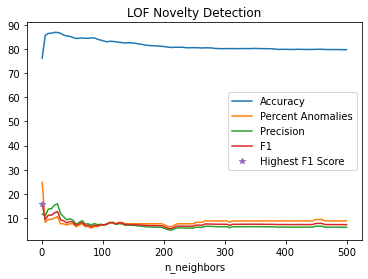

0.1590909090909091
1.0


In [21]:
plotvar(n_est3, acc3, p_anom3, prec3, f13, time3, 'LOF Novelty Detection', 'n_neighbors', 'stand', 0)
ind = np.argmax(f13)
print(max(f13))
print(n_est3[ind])

In [22]:
m = 100
n_est1 = np.linspace(10, 4000, m)
acc1 = np.zeros(m)
f11 = np.zeros(m)
p_anom1 = np.zeros(m)
rtime1 = np.zeros(m)
prec1 = np.zeros(m)
for i in range(m):
    start = timeit.default_timer()
    model = IsolationForest(n_estimators = int(n_est1[i]), max_samples=10,max_features=6)
    model.fit(X_train)
    est_ytest2 = model.predict(X_test)
    stop = timeit.default_timer()
    
    [acc1, f11, p_anom1, prec1] = calc_stats(acc1, f11, p_anom1, prec1, est_ytest2, newy_test)
    rtime1[i] = stop - start

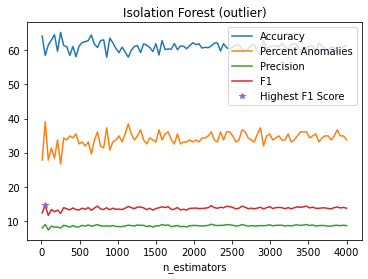

0.1456953642384106


50.303030303030305

In [23]:
plotvar(n_est1, acc1, p_anom1, prec1, f11, rtime1, 'Isolation Forest (outlier)', 'n_estimators','stand',0)
ind = np.argmax(f11)
print(f11[ind])
n_est1[ind]

In [24]:
m = 100
n_est_ = np.linspace(5, 1000, m)
acc_ = np.zeros(m)
f1_ = np.zeros(m)
p_anom_ = np.zeros(m)
rtime_ = np.zeros(m)
prec_ = np.zeros(m)
for i in range(m):
    start = timeit.default_timer()
    model = IsolationForest(n_estimators = 27, max_samples=int(n_est_[i]),max_features=6)
    model.fit(X_train)
    est_ytest2 = model.predict(X_test)
    stop = timeit.default_timer()
    
    [acc_, f1_, p_anom_, prec_] = calc_stats(acc_, f1_, p_anom_, prec_, est_ytest2, newy_test)
    rtime_[i] = stop - start

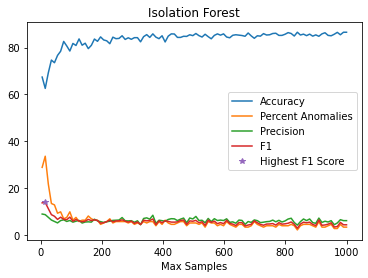

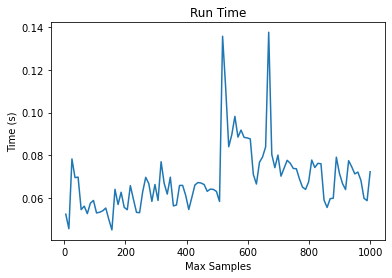

0.14039408866995073


15.05050505050505

In [25]:
plotvar(n_est_, acc_, p_anom_, prec_, f1_, rtime_, 'Isolation Forest', 'Max Samples','stand',1)
ind = np.argmax(f1_)
print(f1_[ind])
n_est_[ind]

In [26]:
m = 100
n_est2 = np.linspace(1, 400, m)
acc2 = np.zeros(m)
f12 = np.zeros(m)
p_anom2 = np.zeros(m)
time2 = np.zeros(m)
prec2 = np.zeros(m)
for i in range(m):
    start = timeit.default_timer()
    clf = LocalOutlierFactor(n_neighbors = int(n_est2[i]))
    est_y = clf.fit_predict(X_)
    stop = timeit.default_timer()
    
    [acc2, f12, p_anom2, prec2] = calc_stats(acc2, f12, p_anom2, prec2, est_y, newy)
    time2[i] = stop - start
    

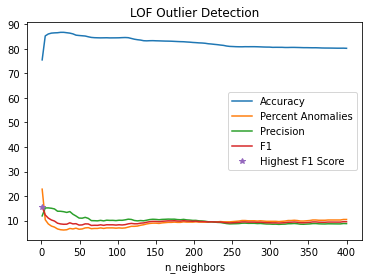

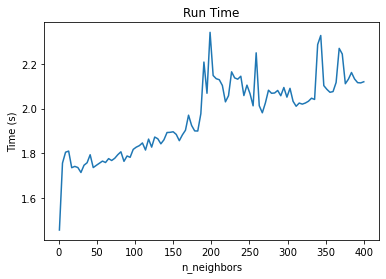

0.15707964601769914
1.0


In [27]:
plotvar(n_est2, acc2, p_anom2, prec2, f12, time2, 'LOF Outlier Detection', 'n_neighbors','stand',1)
ind = np.argmax(f12)
print(max(f12))
print(n_est2[ind])

In [28]:
m = 100
acc1 = np.zeros(m)
f11 = np.zeros(m)
p_anom1 = np.zeros(m)
rtime1 = np.zeros(m)
prec1 = np.zeros(m)
for i in range(m):
    start = timeit.default_timer()
    model = IsolationForest(n_estimators = 10, max_samples=30,max_features=6)
    model.fit(X_train)
    est_ytest2 = model.predict(X_test)
    stop = timeit.default_timer()
    
    [acc1, f11, p_anom1, prec1] = calc_stats(acc1, f11, p_anom1, prec1, est_ytest2, newy_test)
    rtime1[i] = stop - start

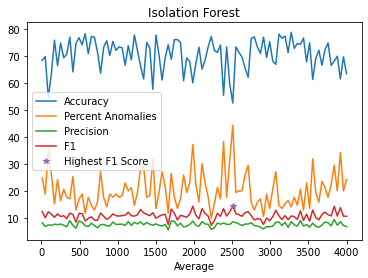

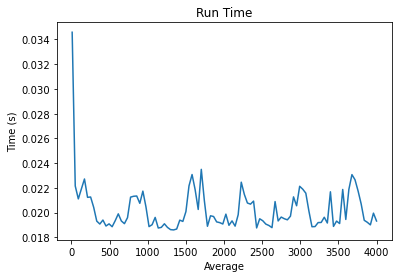

Highest F1 score recorded: 0.14506769825918764
Average F1 score: 0.10994846782305562
Standard Deviation: 0.014007089263361062


In [268]:
plotvar(n_est1, acc1, p_anom1, prec1, f11, rtime1, 'Isolation Forest', 'Average',1)
ind = np.argmax(f11)
print('Highest F1 score recorded:',f11[ind])
print('Average F1 score:',np.mean(f11))
print('Standard Deviation:',np.std(f11))

## Standardized PCA

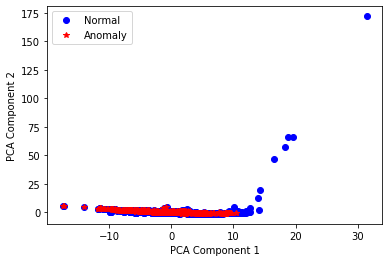

In [29]:
X1, y1 = pca_mle(X, y)

In [30]:
X_, y_ = limit_y(X1, y1, .10)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state = 3)

In [32]:
newy_test = cy(y_test)
newy = cy(y_)

In [33]:
#outlier detecter
clf = LocalOutlierFactor(n_neighbors = 1)
est_y = clf.fit_predict(X_)
print_stats(est_y, newy)

Accuracy: 75.69161484023161

F1 Score: 0.17413479052823316

Percent Anomalies Found: 25.643776824034337


In [34]:
#novelty detection
nov = LocalOutlierFactor(n_neighbors = 1, novelty = True)
nov.fit(X_train)
est_ytest = nov.predict(X_test)
print_stats(est_ytest, newy_test)

Accuracy: 75.29474812433011

F1 Score: 0.14471243042671617

Percent Anomalies Found: 23.076923076923077


In [35]:
#isolation forest
model = IsolationForest(n_estimators=61, max_samples=10,max_features=1)
model.fit(X_train)
est_ytest2 = model.predict(X_test)
print_stats(est_ytest2, newy_test)

Accuracy: 58.78885316184351

F1 Score: 0.14078212290502795

Percent Anomalies Found: 37.278106508875744


In [36]:
m = 100
n_est3 = np.linspace(1, 500, m)
acc3 = np.zeros(m)
f13 = np.zeros(m)
p_anom3 = np.zeros(m)
time3 = np.zeros(m)
prec3 = np.zeros(m)
for i in range(m):
    start = timeit.default_timer()
    nov = LocalOutlierFactor(n_neighbors = int(n_est3[i]), novelty = True)
    nov.fit(X_train)
    est_ytest = nov.predict(X_test)
    stop = timeit.default_timer()
    
    [acc3, f13, p_anom3, prec3] = calc_stats(acc3, f13, p_anom3, prec3, est_ytest, newy_test)
    time3[i] = stop - start
   

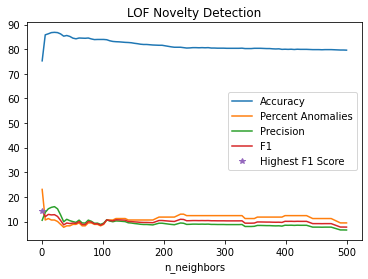

0.14471243042671617
1.0


In [37]:
plotvar(n_est3, acc3, p_anom3, prec3, f13, time3, 'LOF Novelty Detection', 'n_neighbors','spca',0)
ind = np.argmax(f13)
print(max(f13))
print(n_est3[ind])

In [38]:
m = 100
n_est1 = np.linspace(10, 4000, m)
acc1 = np.zeros(m)
f11 = np.zeros(m)
p_anom1 = np.zeros(m)
rtime1 = np.zeros(m)
prec1 = np.zeros(m)
for i in range(m):
    start = timeit.default_timer()
    model = IsolationForest(n_estimators = int(n_est1[i]), max_samples=10,max_features=6)
    model.fit(X_train)
    est_ytest2 = model.predict(X_test)
    stop = timeit.default_timer()
    
    [acc1, f11, p_anom1, prec1] = calc_stats(acc1, f11, p_anom1, prec1, est_ytest2, newy_test)
    rtime1[i] = stop - start

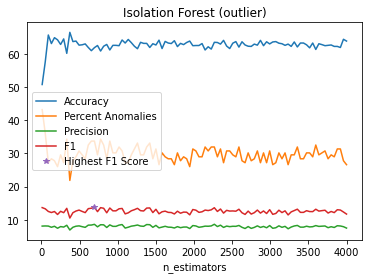

0.13801452784503632


695.1515151515151

In [39]:
plotvar(n_est1, acc1, p_anom1, prec1, f11, rtime1, 'Isolation Forest (outlier)', 'n_estimators','spca',0)
ind = np.argmax(f11)
print(f11[ind])
n_est1[ind]

In [40]:
m = 100
n_est_ = np.linspace(5, 1000, m)
acc_ = np.zeros(m)
f1_ = np.zeros(m)
p_anom_ = np.zeros(m)
rtime_ = np.zeros(m)
prec_ = np.zeros(m)
for i in range(m):
    start = timeit.default_timer()
    model = IsolationForest(n_estimators = 27, max_samples=int(n_est_[i]),max_features=6)
    model.fit(X_train)
    est_ytest2 = model.predict(X_test)
    stop = timeit.default_timer()
    
    [acc_, f1_, p_anom_, prec_] = calc_stats(acc_, f1_, p_anom_, prec_, est_ytest2, newy_test)
    rtime_[i] = stop - start

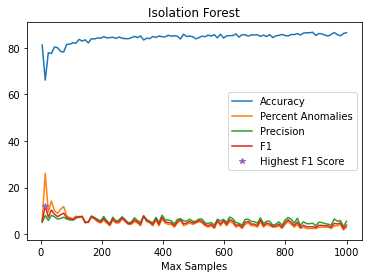

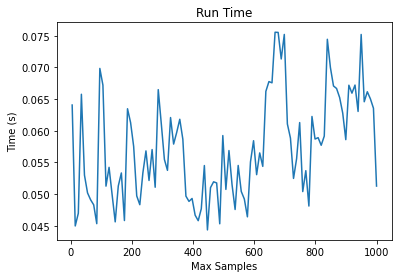

0.12239221140472879


15.05050505050505

In [41]:
plotvar(n_est_, acc_, p_anom_, prec_, f1_, rtime_, 'Isolation Forest', 'Max Samples','spca',1)
ind = np.argmax(f1_)
print(f1_[ind])
n_est_[ind]

In [42]:
m = 100
n_est2 = np.linspace(1, 400, m)
acc2 = np.zeros(m)
f12 = np.zeros(m)
p_anom2 = np.zeros(m)
time2 = np.zeros(m)
prec2 = np.zeros(m)
for i in range(m):
    start = timeit.default_timer()
    clf = LocalOutlierFactor(n_neighbors = int(n_est2[i]))
    est_y = clf.fit_predict(X_)
    stop = timeit.default_timer()
    
    [acc2, f12, p_anom2, prec2] = calc_stats(acc2, f12, p_anom2, prec2, est_y, newy)
    time2[i] = stop - start
    

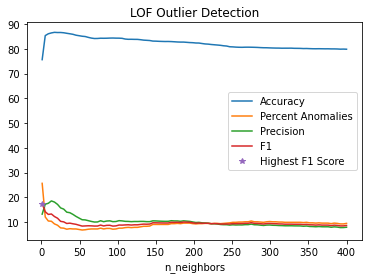

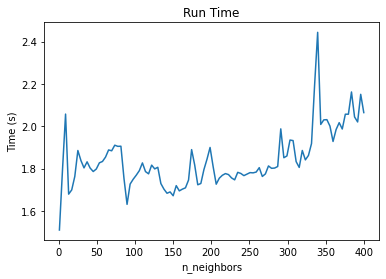

0.17413479052823316
1.0


In [43]:
plotvar(n_est2, acc2, p_anom2, prec2, f12, time2, 'LOF Outlier Detection', 'n_neighbors','spca',1)
ind = np.argmax(f12)
print(max(f12))
print(n_est2[ind])

In [44]:
m = 100
acc1 = np.zeros(m)
f11 = np.zeros(m)
p_anom1 = np.zeros(m)
rtime1 = np.zeros(m)
prec1 = np.zeros(m)
for i in range(m):
    start = timeit.default_timer()
    model = IsolationForest(n_estimators = 10, max_samples=30,max_features=6)
    model.fit(X_train)
    est_ytest2 = model.predict(X_test)
    stop = timeit.default_timer()
    
    [acc1, f11, p_anom1, prec1] = calc_stats(acc1, f11, p_anom1, prec1, est_ytest2, newy_test)
    rtime1[i] = stop - start

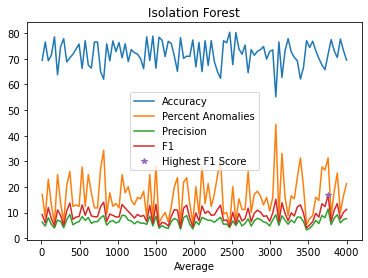

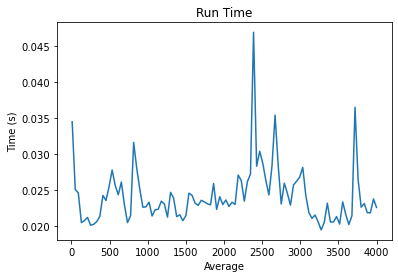

Highest F1 score recorded: 0.16745655608214852
Average F1 score: 0.09278043447444004
Standard Deviation: 0.027374522018697063


In [285]:
plotvar(n_est1, acc1, p_anom1, prec1, f11, rtime1, 'Isolation Forest', 'Average',1)
ind = np.argmax(f11)
print('Highest F1 score recorded:',f11[ind])
print('Average F1 score:',np.mean(f11))
print('Standard Deviation:',np.std(f11))

## Not Standardized

In [45]:
voldata = pd.read_csv('all.csv')

In [46]:
X = np.concatenate((voldata[voldata.columns[1:18]].values[0:8395],voldata[voldata.columns[1:18]].values[8395:]), axis=0)
y = np.concatenate((voldata[voldata.columns[18]].values[0:8395],voldata[voldata.columns[18]].values[8395:]), axis=0)

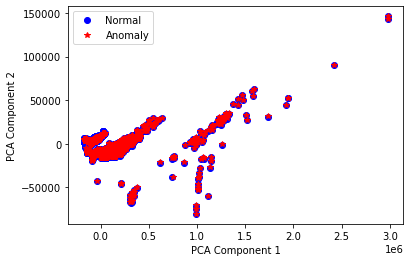

In [47]:
X, y = pca_mle(X, y)

In [48]:
X_, y_ = limit_y(X, y, .10)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state = 3)

In [50]:
newy_test = cy(y_test)
newy = cy(y_)

In [51]:
#outlier detecter
clf = LocalOutlierFactor(n_neighbors = 1)
est_y = clf.fit_predict(X_)
print_stats(est_y, newy)

Accuracy: 75.28415183358354

F1 Score: 0.19377404686953478

Percent Anomalies Found: 29.721030042918457


In [52]:
#novelty detection
nov = LocalOutlierFactor(n_neighbors = 1, novelty = True)
nov.fit(X_train)
est_ytest = nov.predict(X_test)
print_stats(est_ytest, newy_test)

Accuracy: 73.15112540192926

F1 Score: 0.1406518010291595

Percent Anomalies Found: 24.2603550295858


In [53]:
#isolation forest
model = IsolationForest(n_estimators=10, max_samples=10,max_features=1)
model.fit(X_train)
est_ytest2 = model.predict(X_test)
print_stats(est_ytest2, newy_test)

Accuracy: 46.141479099678456

F1 Score: 0.16458852867830426

Percent Anomalies Found: 58.57988165680473


In [55]:
m = 100
n_est3 = np.linspace(1, 500, m)
acc3 = np.zeros(m)
f13 = np.zeros(m)
p_anom3 = np.zeros(m)
time3 = np.zeros(m)
prec3 = np.zeros(m)
for i in range(m):
    start = timeit.default_timer()
    nov = LocalOutlierFactor(n_neighbors = int(n_est3[i]), novelty = True)
    nov.fit(X_train)
    est_ytest = nov.predict(X_test)
    stop = timeit.default_timer()
    
    [acc3, f13, p_anom3, prec3] = calc_stats(acc3, f13, p_anom3, prec3, est_ytest, newy_test)
    time3[i] = stop - start
   

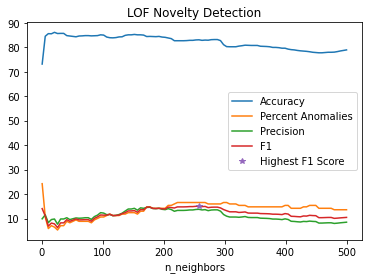

0.15053763440860216
258.06060606060606


In [56]:
plotvar(n_est3, acc3, p_anom3, prec3, f13, time3, 'LOF Novelty Detection', 'n_neighbors','norm',0)
ind = np.argmax(f13)
print(max(f13))
print(n_est3[ind])

In [57]:
m = 100
n_est1 = np.linspace(10, 4000, m)
acc1 = np.zeros(m)
f11 = np.zeros(m)
p_anom1 = np.zeros(m)
rtime1 = np.zeros(m)
prec1 = np.zeros(m)
for i in range(m):
    start = timeit.default_timer()
    model = IsolationForest(n_estimators = int(n_est1[i]), max_samples=10,max_features=6)
    model.fit(X_train)
    est_ytest2 = model.predict(X_test)
    stop = timeit.default_timer()
    
    [acc1, f11, p_anom1, prec1] = calc_stats(acc1, f11, p_anom1, prec1, est_ytest2, newy_test)
    rtime1[i] = stop - start

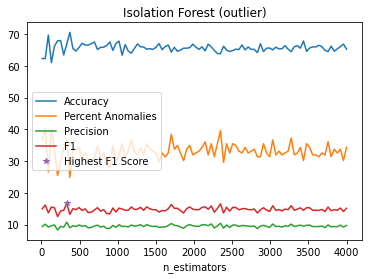

0.16689098250336476


332.42424242424244

In [58]:
plotvar(n_est1, acc1, p_anom1, prec1, f11, rtime1, 'Isolation Forest (outlier)', 'n_estimators','norm',0)
ind = np.argmax(f11)
print(f11[ind])
n_est1[ind]

In [59]:
m = 100
n_est_ = np.linspace(5, 1000, m)
acc_ = np.zeros(m)
f1_ = np.zeros(m)
p_anom_ = np.zeros(m)
rtime_ = np.zeros(m)
prec_ = np.zeros(m)
for i in range(m):
    start = timeit.default_timer()
    model = IsolationForest(n_estimators = 27, max_samples=int(n_est_[i]),max_features=6)
    model.fit(X_train)
    est_ytest2 = model.predict(X_test)
    stop = timeit.default_timer()
    
    [acc_, f1_, p_anom_, prec_] = calc_stats(acc_, f1_, p_anom_, prec_, est_ytest2, newy_test)
    rtime_[i] = stop - start

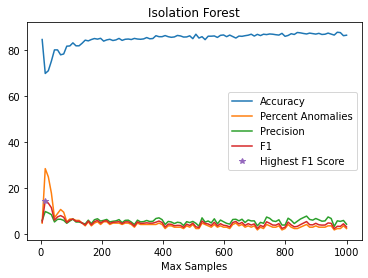

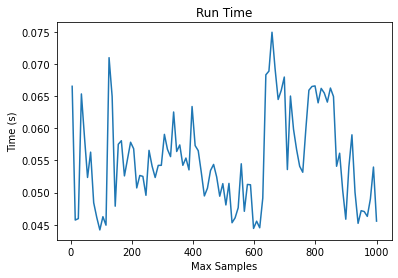

0.14523449319213314
0.04747934916437676


15.05050505050505

In [60]:
plotvar(n_est_, acc_, p_anom_, prec_, f1_, rtime_, 'Isolation Forest', 'Max Samples','norm',1)
ind = np.argmax(f1_)
print(f1_[ind])
print(np.mean(f1_))
n_est_[ind]

In [61]:
m = 100
n_est2 = np.linspace(1, 400, m)
acc2 = np.zeros(m)
f12 = np.zeros(m)
p_anom2 = np.zeros(m)
time2 = np.zeros(m)
prec2 = np.zeros(m)
for i in range(m):
    start = timeit.default_timer()
    clf = LocalOutlierFactor(n_neighbors = int(n_est2[i]))
    est_y = clf.fit_predict(X_)
    stop = timeit.default_timer()
    
    [acc2, f12, p_anom2, prec2] = calc_stats(acc2, f12, p_anom2, prec2, est_y, newy)
    time2[i] = stop - start
    

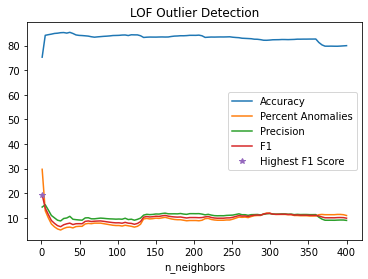

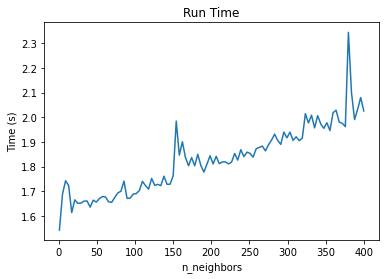

0.19377404686953478
0.09937303929262571
1.0


In [62]:
plotvar(n_est2, acc2, p_anom2, prec2, f12, time2, 'LOF Outlier Detection', 'n_neighbors','norm',1)
ind = np.argmax(f12)
print(max(f12))
print(np.mean(f12))
print(n_est2[ind])

In [ ]:
m = 100
acc1 = np.zeros(m)
f11 = np.zeros(m)
p_anom1 = np.zeros(m)
rtime1 = np.zeros(m)
prec1 = np.zeros(m)
for i in range(m):
    start = timeit.default_timer()
    model = IsolationForest(n_estimators = 10, max_samples=30,max_features=6)
    model.fit(X_train)
    est_ytest2 = model.predict(X_test)
    stop = timeit.default_timer()
    
    [acc1, f11, p_anom1, prec1] = calc_stats(acc1, f11, p_anom1, prec1, est_ytest2, newy_test)
    rtime1[i] = stop - start

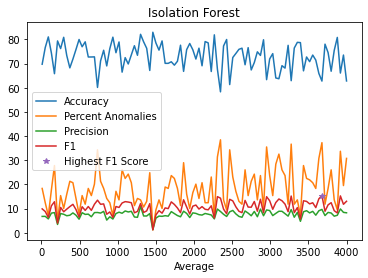

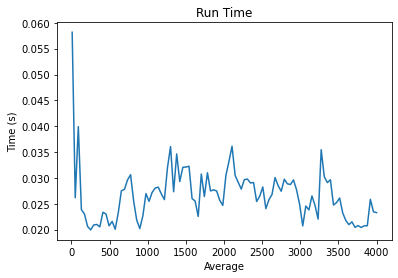

Highest F1 score recorded: 0.15347137637028013
Average F1 score: 0.10629601417692162
Standard Deviation: 0.025223525190730484


In [323]:
plotvar(n_est1, acc1, p_anom1, prec1, f11, rtime1, 'Isolation Forest', 'Average',1)
ind = np.argmax(f11)
print('Highest F1 score recorded:',f11[ind])
print('Average F1 score:',np.mean(f11))
print('Standard Deviation:',np.std(f11))